# Skill assessment - eventwise
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 09-02-2023<br>

**Index**<br>
[__1 Data__](#1-Data)<br>
[1.1 Stations](#1.1-Stations)<br>
[1.2 Exceedance reanalysis](#1.2-Exceedance-reanalysis)<br>
[1.3 Exceedance forecast](#1.3-Exceedance-forecast)<br>
[__2 Compute events__](#2-Compute-events)<br>
[__3 Assess skill__](#3-Assess-skill)<br>
[3.1 Skill within a forecast](#3.1-Skill-within-a-forecast)<br>
[3.2 Skill predicting the onset of the flood](#3.2-Skill-predicting-the-onset-of-the-flood)<br>

**Introduction**:<br>


**Questions**:<br>
* [ ] Weighting the model average by the Brier score?
* [ ] Take into account the model spread?

**Tasks to do**:<br>


**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

path_root = os.getcwd()
path_forecast = '../data/CDS/forecast/'

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from notifications import *
os.chdir(path_root)

## 1 Data

In [2]:
name = 'global'
folders = os.listdir('results/')

In [3]:
# path where results will be saved
path_out = f'results/skill/{name}/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

In [4]:
# coordinate reference system when plotting maps
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))

### 1.1 Stations 

In [5]:
# load selected points for all the catchments
stations = pd.DataFrame()
catchments = []
for folder in folders:
    try:
        stn_cat = pd.read_csv(f'results/{folder}/points_selected.csv', index_col='station_id')
        stations = pd.concat((stations, stn_cat))
        catchments.append(folder)
    except:
        continue
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

# add columns where skill will be saved
new_cols = [f'f1_{model}' for model in ['current', 'model_mean', 'weighted_mean']]
stations[new_cols] = np.nan

no. stations:			739


In [6]:
# shapefile with rivers
rivers_shp = gpd.read_file(f'../data/GIS/RiversForWebPage_EU_ready.shp')
mask = rivers_shp.BASIN.isin(catchments)
rivers_shp = rivers_shp.loc[mask]

### 1.2 Reanalysis: exceedance & events

In [7]:
path_reanalysis = '../data/exceedance/reanalysis/'

# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = pd.read_parquet(f'{path_reanalysis}/exceedance_rl5.parquet')
rean_exc.columns = rean_exc.columns.astype(int)
#start, end = datetime(2021, 1, 1, 6), datetime(2022, 1, 1, 6) + timedelta(hours=39*6)
start, end = datetime(2021, 1, 1, 6), datetime(2022, 1, 10, 12)
rean_exc = rean_exc.loc[start:end, stations.index.tolist()]

In [8]:
# # load probability of exceeding the discharge threshold in the REANALYSIS data
# rean_onsets = pd.read_parquet(f'{path_reanalysis}/events_rl5.parquet')
# rean_onsets.columns = rean_onsets.columns.astype(int)
# rean_onsets = rean_onsets.loc[start:end, stations.index.tolist()]
rean_onsets = rean_exc.astype(int).diff(axis=0) == 1
rean_onsets.iloc[0,:] = rean_exc.iloc[0,:]

In [9]:
# create a DataArray with the number of observed events per station
n_events_obs = xr.DataArray(rean_onsets.sum(), dims=['id'], coords={'id': rean_onsets.columns.tolist()})
print('no. events:\t\t\t{0}'.format(n_events_obs.sum().data))

no. events:			272


In [10]:
# select stations with events
mask_stn = (n_events_obs > 0).to_pandas()
print('no. stations with events:\t{0}'.format(mask_stn.sum()))
# stations = stations.loc[mask_stn,:]
# rean_exc = rean_exc.loc[:,mask_stn]
# rean_onsets = rean_onsets.loc[:,mask_stn]
# print('no. stations with events:\t{0}'.format(stations.shape[0]))

no. stations with events:	194


### 1.3 Exceedance forecast

In [11]:
# models
models = {'COS': {'members': 20, 'leadtimes': 23},
          'DWD': {'members': 1, 'leadtimes': 29},
          'EUD': {'members': 1, 'leadtimes': 40},
          'EUE': {'members': 51, 'leadtimes': 40},}

min_leadtime = min([models[m]['leadtimes'] for m in models])

In [12]:
# load probability of exceeding the discharge threshold in the FORECAST data
path_forecast = '../data/exceedance/forecast/'

fore_exc = {}
for stn in stations.index:
    da = xr.open_dataarray(f'{path_forecast}{stn:04d}.nc')
    if 'id' in da.coords:
        da = da.drop_vars('id')
    fore_exc[stn] = da
    da.close()

# convert into a Dataset
stn = stations.index[0]
fore_exc = xr.Dataset(fore_exc, coords={'model': fore_exc[stn].model,
                                        'forecast': fore_exc[stn].forecast,
                                        'leadtime': fore_exc[stn].leadtime})

In [13]:
# DataArray with weights for each model and leadtime
weights = np.zeros((len(fore_exc.model), len(fore_exc.leadtime)))
for i, (key, value) in enumerate(models.items()):
    leadtimes = value['leadtimes']
    members = value['members']
    weights[i,:leadtimes] = members
weights = xr.DataArray(weights, coords={'model': list(models), 'leadtime': fore_exc.leadtime})

## 2 Compute events

In this section I will create two boolean _DataArray_ with the onset of flood events, i.e., a matrix of zeros and ones where a one means the beginning of a flood.

* `obs_onsets` is a _DataArray_ with three dimensions that contains the "observed" events: 
    * `id`: the stations ID
    * `forecast`: the timestamp of the beginning of the forecast
    * `leadtime`: the timedelta of the specific timestep. The addition of forecast and leadtime renders the actual date and time of the timestep
* `pred_events` is a _DataArray_ with five dimensions that contains the forecasted events:
    * `id`
    * `forecast`
    * `leadtime`
    * `model` corresponds to the different procedures to compute the occcurrence of events.
        * `current` is the current EFAS criteria, i.e., at least a deterministic model must predict the flood, and one of the probabilistic models must predict a probability of event higher than a probability threshold.
        * `model_mean` computes total probability giving the same weight to every model, i.e., 25% weight to each of the 4 meteorological forcings.
        * `weighted_mean` computes total probability giving the same weight to each run, i.e., probabilistic models (with more than 1 run) have a higher weight.
    * `probability` are different thresholds to consider a flood event.

In [14]:
# dprobability thresholds
thresholds = np.arange(0.05, .96, .05).round(2)
probabilities = xr.DataArray(thresholds, dims=['probability'], coords={'probability': thresholds})

In [15]:
# OBSERVED EVENTS & ONSETS
# ........................
    
obs_onsets = {}
obs_events = {}
for i, stn in enumerate(stations.index): 
    # find onsets
    mask = rean_onsets[stn]
    onsets = rean_onsets.index[mask].tolist()
    obs_onsets[stn] = dataarray_events(onsets, fore_exc.forecast, fore_exc.leadtime)
    
    # find events
    mask = rean_exc[stn]
    exc = rean_exc.index[mask].tolist()
    # create DataArray of the occurrence of events
    obs_events[stn] = dataarray_events(exc, fore_exc.forecast, fore_exc.leadtime)
    
obs_onsets = xr.Dataset(obs_onsets).to_array(dim='id', name='events')
obs_events = xr.Dataset(obs_events).to_array(dim='id', name='events')

```Python
stn = 119

fig, axes = plt.subplots(nrows=2, figsize=(16, 8), sharex=True, sharey=True)

for ax, da in zip(axes, [obs_events.sel(id=stn), obs_onsets.sel(id=stn)]):
    sns.heatmap(da.transpose(), ax=ax, cmap='Blues')
    ax.tick_params(length=0)
```

In [16]:
# PREDICTED EVENTS & ONSETS
# .........................

# CURRENT CRITERIA

# compute events for each probability threshold

# compute exceendace of probability thresholds
current = fore_exc.to_array(dim='id', name='current')
exceedance0 = current > probabilities
# find where the deterministic criteria was fulfilled
deterministic = exceedance0.sel(model=['DWD', 'EUD']).sum('model')
# find where the probabilistic criteria was fulfilled
probabilistic = exceedance0.sel(model=['COS', 'EUE']).sum('model')
# find where both the deterministic and the probabilistic criteria was fulfilled
events0 = ((deterministic >= 1) & (probabilistic >= 1))

# compute the onset of events for each probability threshold

steps0 = events0.astype(int).diff('leadtime') == 1
step0_0 = events0.isel(leadtime=0)
onsets0 = xr.concat((step0_0, steps0), 'leadtime')

# NEW CRITERIA

# compute events for each probability threshold and two new criteria: model mean, weighted mean
model_mean = fore_exc.mean('model').to_array(dim='id', name='model_mean')
weighted_mean = fore_exc.weighted(weights).mean('model').to_array(dim='id', name='weighted_mean')
exceedance12 = xr.merge([model_mean, weighted_mean])
events12 = exceedance12 > probabilities

# compute the onset of events for each probability threshold
steps12 = events12.astype(int).diff('leadtime') == 1
step12_0 = events12.isel(leadtime=0)
onsets12 = xr.concat((step12_0, steps12), 'leadtime')

# join the three criteria
pred_events = xr.merge([events0.to_dataset(name='current'), events12]).to_array(dim='model', name='events')
pred_onsets = xr.merge([onsets0.to_dataset(name='current'), onsets12]).to_array(dim='model', name='onsets')

## 3 Assess skill

In this section I will compute the skill of the EFAS predictions in different ways. In all the following sections I will work with three metrics: recall, precision and the f1-score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f1 = \frac{2 \cdot TP}{2 \cdot TP + FN + FP}$$

### 3.1 Brier score: a probability assessment

This score is specific for binary classification problems and, since it evaluates only positive cases, it is suited for imbalance datasets. The Brier score is the mean square error between predicted and expeted probabilities:

$$BS = \frac{\sum (p_{pred} - p_{obs})^2}{N}$$ 

To compare several models, the **Brier skill score** computes the skill of a model relative to a benchmark model:

$$BSS = 1 - \frac{BS_i}{BS_{ref}}$$

**Observed probability of exceendace**

In [17]:
# create a DataArray with observed threshold exceedance
obs = df2da(rean_exc, dims=['id', 'datetime'], plot=False, figsize=(16, 20), title='observed exceendace')

# expected probability of an exceedance
obs = obs.astype(int)
print(obs.dims)
print(obs.shape)

('id', 'datetime')
(739, 1498)


**Predicted probability of exceedance**

In [18]:
# create DataArray of predicted exceedance
pred = fore_exc.to_array(dim='id')

# reshape the previous DataArray
coords = {'id': pred.id,
          'model': pred.model,
          'leadtime': np.arange(0, min_leadtime) * 12, #[timedelta(hours=int(12 * h)) for h in np.arange(0, 20)],
          'datetime': pd.date_range(start, end, freq='6h')}
pred = reshape_da(pred, coords, loop_dim='leadtime')
print(pred.dims)
print(pred.shape)

('id', 'model', 'leadtime', 'datetime')
(739, 4, 23, 1498)


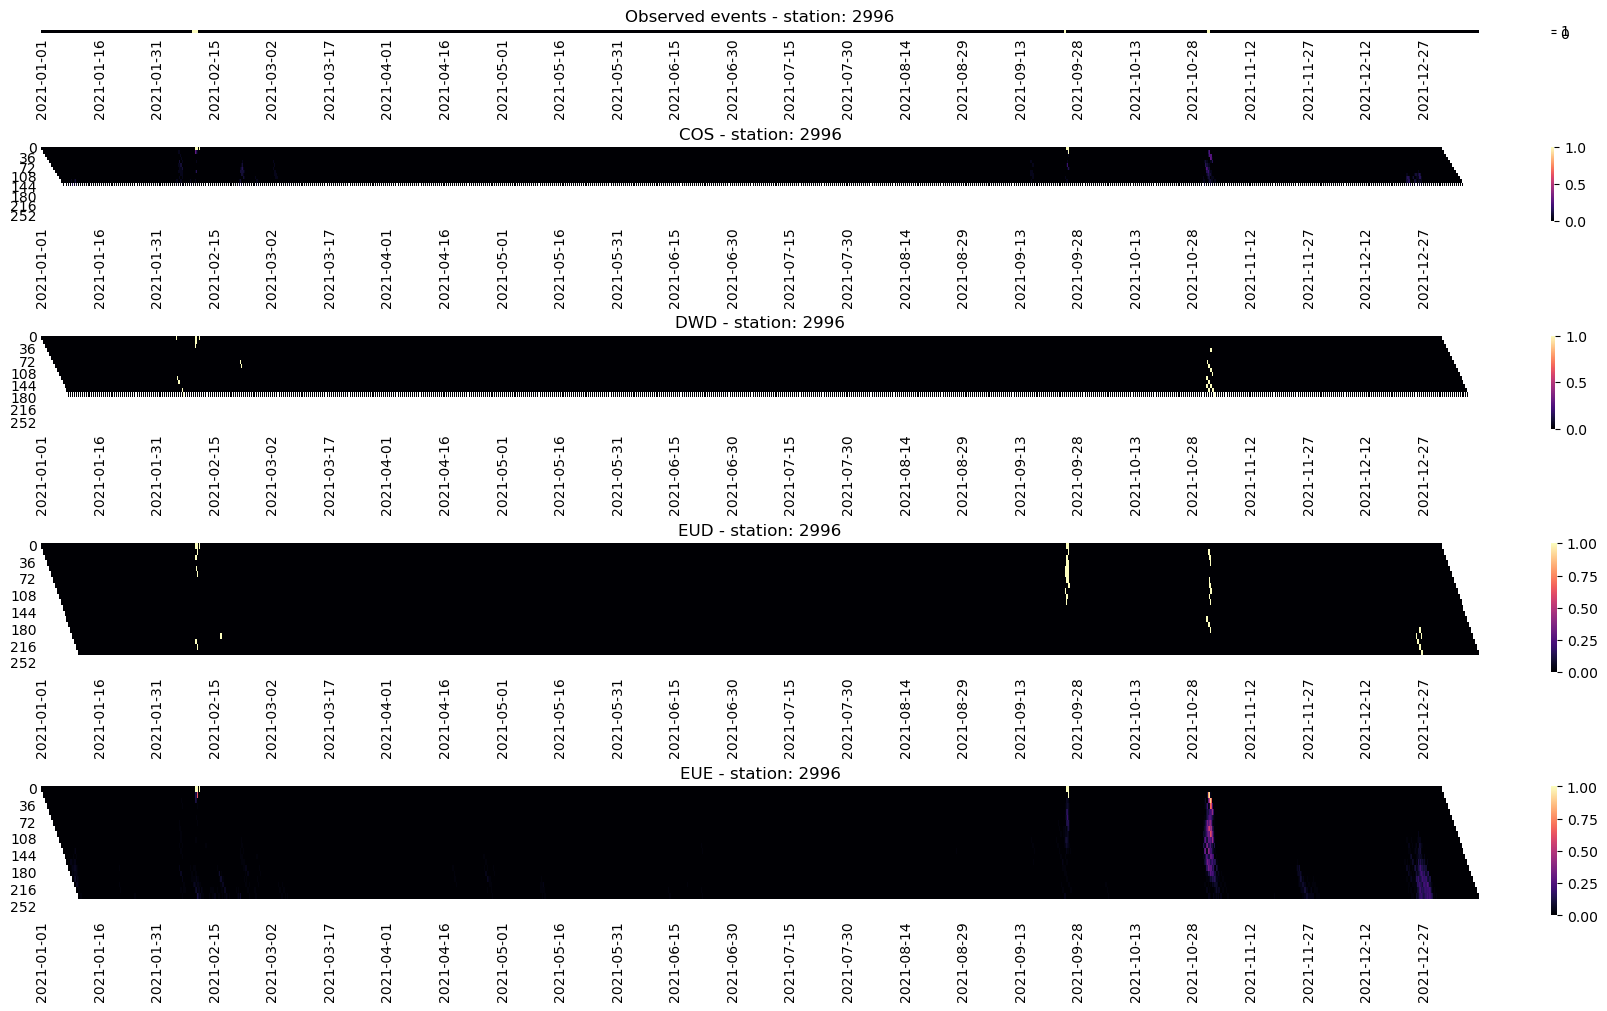

In [19]:
# plot the predicted probabilit for a station and NWP model
stn = 4359
stn = 2996

fig = plt.figure(constrained_layout=True, figsize=(16, 10))
leadtimes = [models[m]['leadtimes'] for m in models]
gs = fig.add_gridspec(nrows=5, height_ratios=[1] + leadtimes)

ax1 = fig.add_subplot(gs[0])
plot_da(obs.sel(id=stn), ax=ax1,
        title=f'Observed events - station: {stn}')

for i, (m, lt) in enumerate(zip(models, leadtimes)):
    ax = fig.add_subplot(gs[i + 1], sharex=ax1)
    da = pred.sel(id=stn, model=m).isel(leadtime=slice(0, lt))
    plot_da(da, ax=ax, title=f'{m} - station: {stn}')

**Skill**

In [20]:
# squared error
se = (obs - pred)**2
# se = se.isel(leadtime=slice(0, min_leadtime)) # keep only the leadtime that is available for all models

# Brier skill of each model and station
brier = se.isel(leadtime=slice(0, min_leadtime)).mean(['leadtime', 'datetime'])

##### All stations

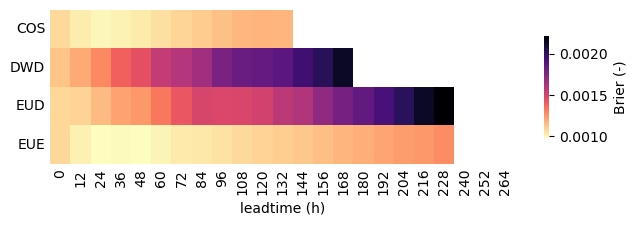

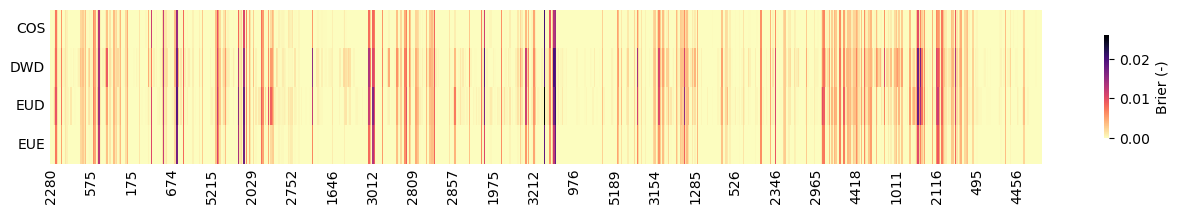

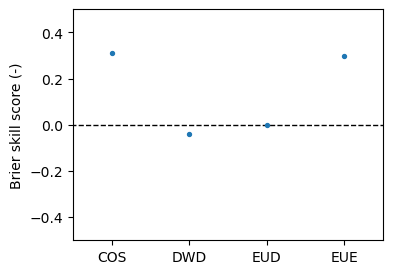

In [21]:
# plot Brier score according to model and forecast
plot_da(se.mean(['datetime', 'id']), xtick_step=1, ytick_step=1, cmap='magma_r', xlabel='leadtime (h)',
        figsize=(7.5, 2), cbar_kws={'label': 'Brier (-)', 'shrink': .666})
plt.savefig(f'{path_out}leadtime_Brier_all_stations.jpg', bbox_inches='tight', dpi=300)

# plot Brier score according to model and station
plot_da(se.mean(['leadtime', 'datetime']).transpose(), yticklabels=se.model.data, ytick_step=1, xticklabels=se.id.data, xtick_step=30,
        cmap='magma_r', cbar_kws={'label': 'Brier (-)', 'shrink': .666})

# Brier skill score in terms of NWP model
BSS = 1 - brier.mean('id') / brier.sel(model='EUD').mean('id')

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(range(0, 4), BSS.data, s=8)
ax.hlines(0, -1, 5, 'k', ls='--', lw=1, zorder=0)
ax.set_xticks(range(0, 4), BSS.model.data)
ax.set(xlim=(-.5, 3.5), ylim=(-.5, .5), ylabel='Brier skill score (-)');

The previous plot shows The Brier skill score using as a benchmark the ECMWF deterministic EUD. Positive values represent models better than the reference, whereas negative values represent models worse than the reference. As seen previously, the two probabilistic models have a higher skill than the reference, with ECMWF ensemble as the best forcing. The DWD is the worst of all the forcings.

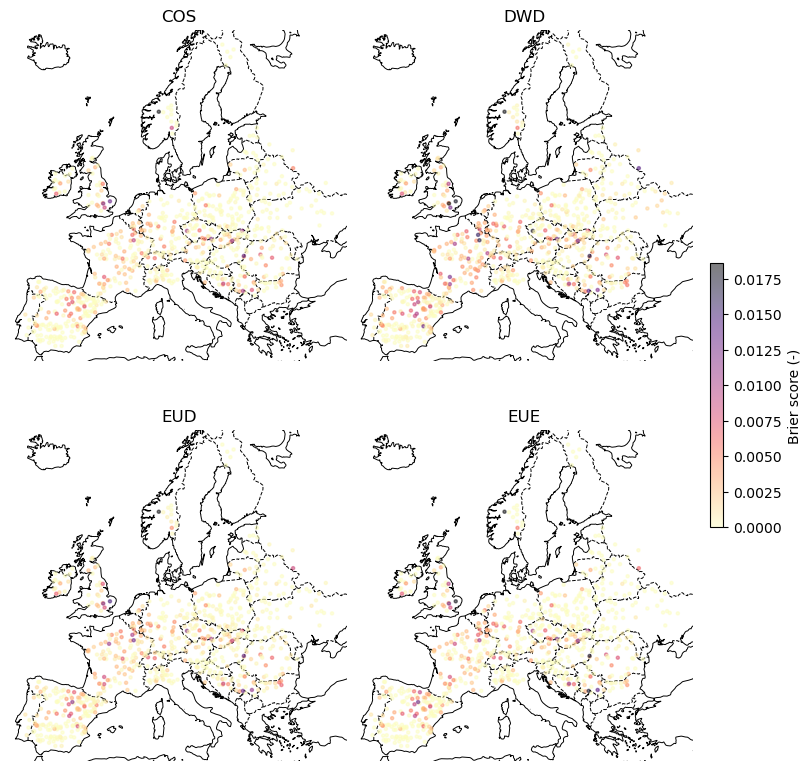

In [22]:
# plot a map of the Brier score 
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, model in zip(axes.flatten(), brier.model.data):
    plot_map_stations(stations.X, stations.Y, brier.sel(model=model).to_pandas(), ax=ax,
                      rivers=None, size=5, cmap='magma_r', title=model)#, vmin=0, vmax=.022)
fig.colorbar(plot_map_stations.colorbar, ax=axes[:,1], shrink=.333, label=f'Brier score (-)');

plt.savefig(f'{path_out}eventwise_Brier_all_stations.jpg', bbox_inches='tight', dpi=300)

##### Stations with events

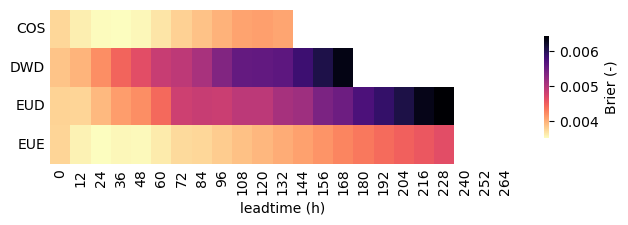

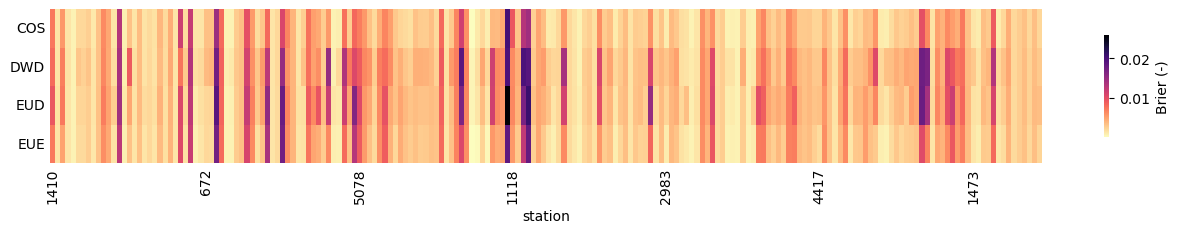

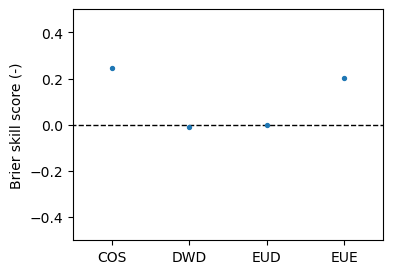

In [23]:
# select stations with events
se_ = se.sel(id=stations[mask_stn].index)

# plot Brier score according to model and forecast
plot_da(se_.mean(['datetime', 'id']), xtick_step=1, ytick_step=1, cmap='magma_r', xlabel='leadtime (h)',
        figsize=(7.5, 2), cbar_kws={'label': 'Brier (-)', 'shrink': .666})
plt.savefig(f'{path_out}leadtime_Brier_stations_with_events.jpg', bbox_inches='tight', dpi=300)

# plot Brier score according to model and station
plot_da(se_.mean(['leadtime', 'datetime']).transpose(), ytick_step=1, xtick_step=30, xlabel='station',
        cmap='magma_r', cbar_kws={'label': 'Brier (-)', 'shrink': .666})

# Brier skill score in terms of NWP model
BSS = 1 - brier.sel(id=stations[mask_stn].index).mean('id') / brier.sel(model='EUD', id=stations[mask_stn].index).mean('id')

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(range(0, 4), BSS.data, s=8)
ax.hlines(0, -1, 5, 'k', ls='--', lw=1, zorder=0)
ax.set_xticks(range(0, 4), BSS.model.data)
ax.set(xlim=(-.5, 3.5), ylim=(-.5, .5), ylabel='Brier skill score (-)');

These two previous plots show that the determinitic forcings (COS and EUE) have a better Brier score than the deterministic forcings (DWD and EUE). Between the two deterministic forcings, EUD seems to have a larger leadtime skill (up to the 5th forecast).

Regarding the stations (plot at the bottom), it seems that the stations at the heawaters (left side of the plot) have a higher skill than the rest.

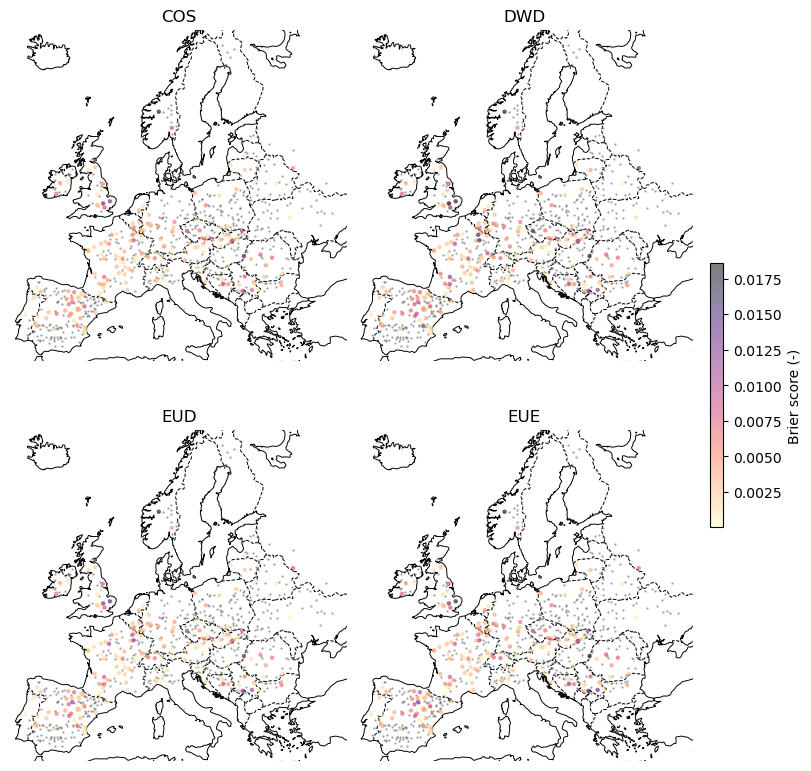

In [24]:
# plot a map of the Brier score 
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, model in zip(axes.flatten(), brier.model.data):
    plot_map_stations(stations.X, stations.Y, brier.sel(model=model).to_pandas(), mask=~mask_stn, ax=ax,
                      rivers=None, size=5, cmap='magma_r', title=model)#, vmin=0, vmax=.022)
fig.colorbar(plot_map_stations.colorbar, ax=axes[:,1], shrink=.333, label=f'Brier score (-)');

plt.savefig(f'{path_out}eventwise_Brier_stations_with_events.jpg', bbox_inches='tight', dpi=300)

### 3.2 Where events predicted at any point in time?

The objective of this section is to check if actual events where predicted at all, no matter leadtime.

**Exceedance over probability threshold**

In [ ]:
# exceedance according to current criteria
deterministic = (pred.sel(model=['EUD', 'DWD']) > probabilities).any('model')
probabilistic = (pred.sel(model=['EUE', 'COS']) > probabilities).any('model')
current = deterministic & probabilistic

# exceedance according to mean over models
model_mean = pred.mean('model', skipna=True) > probabilities

# exceedance according to the weighted mean over models
# limit the DataArray `weights` to 20 timesteps
weights_20  = weights.isel(leadtime=slice(0, 20))
weights_20['leadtime'] = pred.leadtime
weighted_mean = pred.weighted(weights_20).mean('model', skipna=True) > probabilities

# merge all in a single DataArray
pred_reshape = xr.Dataset({'current': current,
                           'model_mean': model_mean,
                           'weighted_mean': weighted_mean}).to_array(dim='model')

In [ ]:
pred.shape

In [ ]:
weights_20

In [ ]:
weight_brier = se.mean(['datetime', 'id']).dropna('leadtime')

sns.heatmap(weight_brier)

> <font color=red>Create the probability weighted by the Brier score.</font>

**Graphical explanation of the procedure**

In [ ]:
stn = n_events_obs.idxmax().data
stn = 119
#stn = 4359
#stn = 2996
stn = 2753
stn = 2376
print('Station {0} has {1} observed events'.format(stn, n_events_obs.sel(id=stn).data))

In [ ]:
das = {'obs': obs.sel(id=stn), 
       'pred': pred_reshape.sel(id=stn, probability=.3, model='weighted_mean').any('leadtime').astype(int)}

n_events_pred = (xr.concat([das['pred'].isel(datetime=[0]), das['pred'].diff('datetime')], dim='datetime') == 1).sum('datetime').data
print('Station {0} has {1} predicted events'.format(stn, n_events_pred))

fig, axes = plt.subplots(nrows=2, figsize=(16, 1), sharex=True, sharey=True)
for ax, (title, da) in zip(axes, das.items()):
    plot_da(da, ax=ax, xtick_step=60, cbar=False)

In [ ]:
# rolling sum of observations and predictions
w = 7
mp = int(w / 2) + 1
das_w = {key: das[key].rolling({'datetime': w}, center=True, min_periods=mp).sum() > 0 for key in das}

fig, axes = plt.subplots(nrows=2, figsize=(16, 1), sharex=True, sharey=True)
for ax, (title, da) in zip(axes, das_w.items()):
    plot_da(da, ax=ax, xtick_step=60, cbar=False)

In [ ]:
# compute true positives and false negatives
aux1 = das_w['pred'].where(das['obs'] == 1)
tp, fn = (aux1 == 1).astype(int), (aux1 == 0).astype(int)

# compute false positives
aux2 = das['pred'].where(das_w['obs'] == 0)
fp = (aux2 == 1).astype(int)

fig, axes = plt.subplots(nrows=3, figsize=(16, 1.5), sharex=True, sharey=True)
for ax, da in zip(axes, [tp, fn, fp]):
    plot_da(da, ax=ax, xtick_step=60, cbar=False)

In [ ]:
TP = (tp.isel(datetime=0) + (tp.diff('datetime') == 1)).sum('datetime')
TP = xr.ufuncs.minimum(TP, n_events_obs.sel(id=stn)).data
FN = n_events_obs.sel(id=stn).data - TP
FP = max(0, n_events_pred - TP)

TP, FN, FP

In [ ]:
TP / (TP + FN), TP / (TP + FP), 2 * TP / (2 * TP + FP + FN)

**Compute for all the stations**

In [ ]:
# DataArrays of exceedance over threshold
das = {'obs': obs, 
       'pred': pred_reshape.any('leadtime').astype(int)} #.sel(probability=.3)

n_events_pred = (xr.concat([das['pred'].isel(datetime=[0]), das['pred'].diff('datetime')], dim='datetime') == 1).sum('datetime').data

# rolling sum of observations and predictions
w = 7
mp = int(w / 2) + 1
das_w = {key: das[key].rolling({'datetime': w}, center=True, min_periods=mp).sum() > 0 for key in das}

# compute true positives
tp = (das_w['pred'].where(das['obs']) == 1).astype(int)
tp = (tp.isel(datetime=0) + (tp.diff('datetime') == 1)).sum('datetime')
tp = xr.ufuncs.minimum(tp, n_events_obs)
# compute false negatives and false positives
fn = n_events_obs - tp
fp = xr.ufuncs.maximum(0, n_events_pred - tp)

# compute metrics
skill = xr.Dataset({'recall': tp / (tp + fn),
                   'precision': tp / (tp + fp),
                   'f1': 2 * tp / (2 * tp + fp + fn)})#.to_array(dim='metric')

**All the stations**

In [ ]:
# plot performace for individual stations
filename = f'{path_out}eventwise_station_skill_(all_stations).jpg'
plot_skill(skill, xtick_step=50, save=filename)

In [ ]:
# plot average performance over stations
fig, axes = plt.subplots(nrows=len(skill.model), figsize=(8, 3), constrained_layout=True, sharex=True, sharey=True)
for i, (ax, model) in enumerate(zip(axes, skill.model.data)):
    da = skill.sel(model=model).mean('id').to_array(dim='metric')
    if i == 1:
        cbar = True
    else:
        cbar = False
    plot_da(da, xtick_step=1, ytick_step=1, cmap='Blues', ax=ax, vmin=0, vmax=1, cbar=cbar, title=model,
            cbar_kws={'shrink': 1.5, 'label': 'metric (-)'})
    if i == len(skill.model) - 1:
        ax.set_xlabel('probability (-)')
        
    print(model.upper().replace('_', ' '))
    print('-' * len(model))
    print('Best probability thresholds\n{0}:\t\t{3:.3f}\n{1}:\t{4:.3f}\n{2}:\t\t{5:.3f}\n'.format(*da.metric.data, *da.idxmax('probability').data))
    
plt.savefig(f'{path_out}eventwise_average_skill_(all_stations).jpg', bbox_inches='tight', dpi=300)

In [ ]:
# find probability threshold that optimizes f1 for a given model
metric = 'f1'
model = 'weighted_mean'
best_p = skill[metric].sel(model=model).mean('id').idxmax(dim='probability', skipna=True)

# plot a map of the metrics
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, metric in zip(axes, list(skill)):
    # extract metric values for stations
    metric_id = skill[metric].sel(model=model, probability=best_p).to_pandas()
    # plot a map of the Brier score for the COS model
    plot_map_stations(stations.X, stations.Y, metric_id, ax=ax,
                      rivers=None, size=8, cmap='coolwarm_r', title=metric)
fig.text(.475, 1.025, f'{model} | p = {best_p.data:.2f}', horizontalalignment='center', fontsize=13)
fig.colorbar(plot_map_stations.colorbar, shrink=.5, label=f'(-)');

plt.savefig(f'{path_out}eventwise_skill_map_(all_stations).jpg', bbox_inches='tight', dpi=300)

**Stations with events**

In [ ]:
# plot performace for individual stations
stn = stations[mask_stn].index
filename = f'{path_out}eventwise_station_skill_(stations_with_events).jpg'
plot_skill(skill.sel(id=stn), xtick_step=50, save=filename)

In [ ]:
# plot average performance over stations
stn = stations[mask_stn].index
fig, axes = plt.subplots(nrows=len(skill.model), figsize=(8, 3), constrained_layout=True, sharex=True, sharey=True)
for i, (ax, model) in enumerate(zip(axes, skill.model.data)):
    da = skill.sel(model=model, id=stn).mean('id').to_array(dim='metric')
    if i == 1:
        cbar = True
    else:
        cbar = False
    plot_da(da, xtick_step=1, ytick_step=1, cmap='Blues', ax=ax, vmin=0, vmax=1, cbar=cbar, title=model,
            cbar_kws={'shrink': 1.5, 'label': 'metric (-)'})
    if i == len(skill.model) - 1:
        ax.set_xlabel('probability (-)')
        
    print(model.upper().replace('_', ' '))
    print('-' * len(model))
    print('Best probability thresholds\n{0}:\t\t{3:.3f}\n{1}:\t{4:.3f}\n{2}:\t\t{5:.3f}\n'.format(*da.metric.data, *da.idxmax('probability').data))
    
plt.savefig(f'{path_out}eventwise_average_skill_(stations_with_events).jpg', bbox_inches='tight', dpi=300)

In [ ]:
# find probability threshold that optimizes f1 for a given model
metric = 'f1'
model = 'weighted_mean'
stn = stations[mask_stn].index
best_p = skill[metric].sel(model=model, id=stn).mean('id').idxmax(dim='probability', skipna=True)

# plot a map of the metrics
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, metric in zip(axes, list(skill)):
    # extract metric values for stations
    metric_id = skill[metric].sel(model=model, probability=best_p).to_pandas()
    # plot a map of the Brier score for the COS model
    plot_map_stations(stations.X, stations.Y, metric_id, mask=~mask_stn, ax=ax,
                      rivers=None, size=8, cmap='coolwarm_r', title=metric)
fig.text(.475, 1.025, f'{model} | p = {best_p.data:.2f}', horizontalalignment='center', fontsize=13)
fig.colorbar(plot_map_stations.colorbar, shrink=.5, label=f'(-)');

plt.savefig(f'{path_out}eventwise_skill_map_(stations_with_events).jpg', bbox_inches='tight', dpi=300)